In [1]:
import os
import cv2
import plotly.graph_objects as go
from tqdm import tqdm
from datetime import datetime

from utilities.ArUco_detector import get_marker_positions, extract_2d_marker_positions, detections_to_json, clean_invalid_markers
from utilities.camera import load_cameras_from_json
from utilities.visualize import visualize_detections_on_image, add_cameras_to_fig, add_markers_to_fig, add_skeleton_to_fig

In [2]:
calibration_file = 'calibration_dome.json'  # the calibrated camera params
input_base_path = "/data/vci/motion_markers"
sequence_name = "2026_01_29_motion_markers_003"
frame_number = 1 # seq1_n = 36, seq2_n = 209, seq3_n = 207, seq4_n = 106
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_json_path = f"seq_{sequence_name[-3:]}_j12_t{timestamp}.json"
 

In [3]:
uppermost_view_names = ["C0025", "C0030", "C0024", "C0019", "C0031", "C0039"]
upper_view_names = ["C0014", "C0009", "C0016", "C0000"]
middle_view_names = ["C0007", "C0018", "C0004", "C0034", "C0006", "C0008", "C0026", "C0005", "C0028", "C0029", "C0012", "C0038"]
lower_view_names = ["C0022", "C1000", "C0037", "C0021", "C0020", "C1005"]
lowermost_view_names = ["C1001", "C0001", "C0013", "C1004", "C1002", "C0010"]
view_names = uppermost_view_names + upper_view_names + middle_view_names + lower_view_names + lowermost_view_names

my_cameras = load_cameras_from_json(calibration_file, view_names)
scale = 1.0
for cam in my_cameras:
    cam.adjust_intrinsic_for_scale(scale)

In [4]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
detections = [[] for _ in range(len(view_names))]
expected_ids_set = set(range(12))

inputs = []
for frame_idx in tqdm(range(frame_number), desc="Loading Frames & Detecting"):
    found_valid_ids = set()     # Valid IDs found across all cameras for this single frame
    found_invalid_ids = set()   # Bad IDs (outside 0-11 range) found in this frame

    for view_idx, view_name in enumerate(view_names):
        image_path = os.path.join(input_base_path,sequence_name,f"frame_{frame_idx:05d}","rgb",f"{view_name}.png")
        img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        corners, marker_ids, rejected = detector.detectMarkers(img_bgr)
        inputs.append(img_rgb)

        if marker_ids is not None:
            current_ids = marker_ids.flatten()  
            for mid in current_ids:
                if 0 <= mid <= 11:
                    found_valid_ids.add(mid)
                else:
                    found_invalid_ids.add(mid)

        clean_corners, clean_ids = clean_invalid_markers(corners, marker_ids, valid_range=(0, 11))

        detections[view_idx].append({
            "ids": clean_ids,
            "corners": clean_corners
        })
    
    if found_invalid_ids:
        print(f"\n[WARNING] Frame {frame_idx}: Found unexpected marker IDs outside 0-11 range: {sorted(list(found_invalid_ids))}")

    missing_ids = expected_ids_set - found_valid_ids
    if missing_ids:
        print(f"\n[WARNING] Frame {frame_idx}: Incomplete marker set.")
        print(f"          Found {len(found_valid_ids)}/12 unique valid IDs.")
        print(f"          Missing IDs: {sorted(list(missing_ids))}")

marker_positions_over_time = get_marker_positions(
    detections=detections,
    cameras=my_cameras,
    input_is_undistorted=True
)

Loading Frames & Detecting: 100%|██████████| 1/1 [00:32<00:00, 32.40s/it]


In [5]:
detections_to_json(marker_positions_over_time, output_json_path)

Saved formatted marker positions to seq_003_j12_t20260212_123612.json


Found 8 markers. Visualizing detections.


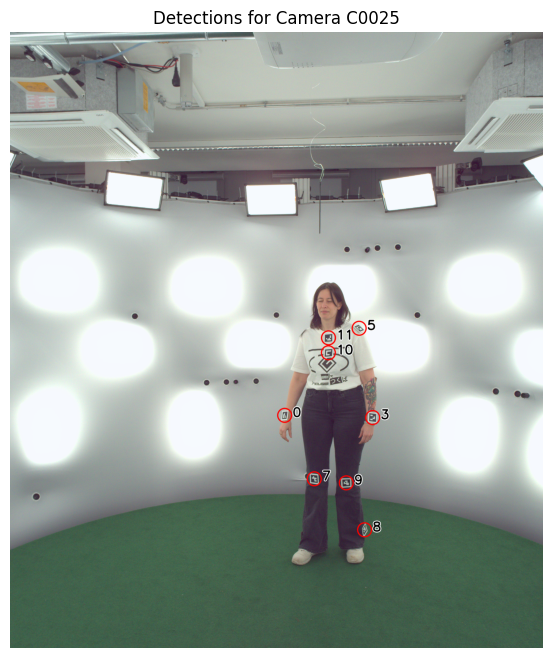

[{'id': 7, 'center': (2630.25, 3864.0)},
 {'id': 9, 'center': (2907.0, 3899.5)},
 {'id': 3, 'center': (3135.0, 3334.25)},
 {'id': 11, 'center': (2753.25, 2645.75)},
 {'id': 10, 'center': (2752.75, 2774.5)},
 {'id': 5, 'center': (3018.75, 2562.0)},
 {'id': 0, 'center': (2374.75, 3315.25)},
 {'id': 8, 'center': (3065.5, 4305.5)}]

In [10]:
camera_id = 10

visualize_detections_on_image(
    inputs[camera_id], 
    detections[camera_id][0], 
    title=f"Detections for Camera C0025"
)

extract_2d_marker_positions(detections[camera_id][0])

In [7]:
fig = go.Figure()
fig = add_cameras_to_fig(fig, my_cameras, scale=0.2)
fig = add_markers_to_fig(fig, marker_positions_over_time)
fig = add_skeleton_to_fig(fig, marker_positions_over_time, [(0,1),(1,2),(2,11),(3,4),(4,5),(5,11),(6,7),(8,9),(10,11)])
fig.update_layout(
    title="VCI ArUco 3D Locations",
    scene=dict(
        xaxis_title='X (meters)',
        yaxis_title='Y (meters)',
        zaxis_title='Z (meters)',
        aspectmode='data',
        camera=dict(
            up=dict(x=0, y=-1, z=0),   # Sets the Z-axis to point 'up'
            eye=dict(x=1.5, y=1.5, z=1.5) # Initial camera position
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()